# inspect llc parcel simulation

In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr

from dask.delayed import delayed
import dask.dataframe as dd

%matplotlib inline
from matplotlib import pyplot as plt

#import xgcm
from h3 import h3

import mitequinox.utils as ut
import mitequinox.parcels as pa

In [13]:
from dask.distributed import Client, LocalCluster
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(jobs=2)
#
client = Client(cluster)
client

Client Scheduler: tcp://10.148.0.96:41063 Dashboard: http://10.148.0.96:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [2]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#cluster = LocalCluster(processes=False, n_workers=4, threads_per_worker=2)
#
#from dask_jobqueue import PBSCluster
# ** processes and cores may be adjusted in order to have more memory or inversely more computational ressource
#cluster = PBSCluster(processes=5, cores=5, walltime='04:00:00')
#cluster = PBSCluster(walltime='04:00:00')
#cluster = PBSCluster()
#w = cluster.scale(jobs=2)
#
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:59925 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 107.37 GB


---
## load data

In [3]:
#root_dir = '/home1/scratch/aponte/parcels/'
#root_dir = '/home1/dunree/slgentil/tmp/parcels/'
root_dir = '/home1/datawork/slgentil/parcels/'

run_name = 'global_T365j_dt1j_dij50'

run_dir = root_dir+run_name

In [4]:
run_dir_tmp = '/home1/datawork/aponte/tmp/' # !!! tmp

### reconstruct parquet files !!! temporary: should be done in parcel_distributed.ipynb

In [6]:
df = pa.load_cdf(run_dir, index='time', persist=True)
pa.store_parquet(run_dir_tmp, df, index='time', overwrite=True)

deleting existing archive: /home1/datawork/aponte/tmp/drifters/time
create new archive: /home1/datawork/aponte/tmp/drifters/time


In [9]:
df = pa.load_cdf(run_dir, index='trajectory', persist=True)
pa.store_parquet(run_dir_tmp, df, index='trajectory', overwrite=True)

distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing


create new archive: /home1/datawork/aponte/tmp/drifters/trajectory


In [16]:
df = pa.load_cdf(run_dir,index='trajectory', persist=True)
df = pa.h3_index(df)
pa.store_parquet(run_dir_tmp, df, index='hex_id', overwrite=True)

deleting existing archive: /home1/datawork/aponte/tmp/drifters/hex_id
create new archive: /home1/datawork/aponte/tmp/drifters/hex_id


---

# drifters geographical distribution

In [142]:
df = dd.read_parquet(run_dir_tmp+'drifters/hex_id')
# filter out weird hex_id=0 values
df = df.map_partitions(lambda df: df.drop('0', errors='ignore'), meta=df)

In [143]:
df

,trajectory,time,lat,lon,z
npartitions=174,,,,,
0,float64,datetime64[ns],float64,float64,float64
82066ffffffffff,...,...,...,...,...
...,...,...,...,...,...
82f327fffffffff,...,...,...,...,...
82f3affffffffff,...,...,...,...,...


In [6]:
# compute a finer geographical distribution
if False:
    from h3 import h3
    def get_hex(row, resolution, *args, **kwargs):
        return h3.geo_to_h3(row["lat"], row["lon"], resolution)

    # resolution = 2 : 86000 km^2
    df['hex_id_fine'] = df.apply(get_hex,
                                 axis=1, 
                                 args=(resolution,), 
                                 meta='string',
                                )

In [126]:
df

,trajectory,time,lat,lon,z
npartitions=174,,,,,
0,float64,datetime64[ns],float64,float64,float64
82066ffffffffff,...,...,...,...,...
...,...,...,...,...,...
82f327fffffffff,...,...,...,...,...
82f3affffffffff,...,...,...,...,...


In [145]:
t_start = df['time'].min().compute()
t_end = df['time'].max().compute()

print(t_start)
print(t_end)

2011-11-15 00:00:00
2012-11-14 01:00:00


In [146]:
#t_bins = pd.date_range(t_start, t_end, freq='1M')
t_bins = pd.date_range(t_start, t_end, freq='1MS') # starts at the beginning of each month
cut = lambda df, bins: pd.cut(df.time, bins=bins)
df['time_cut'] = df.map_partitions(cut, t_bins)

In [147]:
count = (df
         .groupby('time_cut')
         .count()['z']
         .compute()
         .rename('count')
         .to_frame()
        )
count['time'] = count.index.to_series().apply(lambda d: d.left)

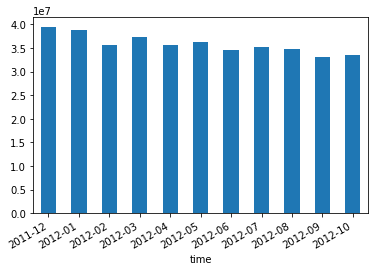

In [148]:
fig, ax = plt.subplots()
count['time'] = count.index.to_series().apply(lambda d: d.left)
count.set_index('time')['count'].plot.bar(ax=ax)
ax.set_xticklabels([pd.Timestamp(t.get_text()).strftime('%Y-%m') for t in ax.get_xticklabels()])
fig.autofmt_xdate()

### bin by month and geographical area

In [165]:
count = (df['z']
         .groupby([df.index, df.time_cut])
         .count()
         .compute()
         .rename('count')
         .to_frame()
        )
count['time'] = count.index.to_series().apply(lambda v: v[1].left)
count['cell_area'] = count.index.to_series().apply(lambda v: h3.cell_area(v[0]))
count['count_normalized'] = count['count']/count['cell_area'] 

In [169]:
count

count     cell_area       time  \
hex_id          time_cut                                                   
820127fffffffff (2011-12-01, 2012-01-01]   6527  68186.637551 2011-12-01   
                (2012-01-01, 2012-02-01]   3422  68186.637551 2012-01-01   
                (2012-02-01, 2012-03-01]   2721  68186.637551 2012-02-01   
                (2012-03-01, 2012-04-01]   8009  68186.637551 2012-03-01   
                (2012-04-01, 2012-05-01]   8920  68186.637551 2012-04-01   
...                                         ...           ...        ...   
82f3affffffffff (2012-06-01, 2012-07-01]   1003  79647.519411 2012-06-01   
                (2012-07-01, 2012-08-01]      0  79647.519411 2012-07-01   
                (2012-08-01, 2012-09-01]    170  79647.519411 2012-08-01   
                (2012-09-01, 2012-10-01]    102  79647.519411 2012-09-01   
                (2012-10-01, 2012-11-01]    397  79647.519411 2012-10-01   

                                          count_normalized  
hex_id          time_cut                                    
820127fffffffff (2011-12-01, 2012-01-01]          0.095723  
                (2012-01-01, 2012-02-01]          0.050186  
                (2012-02-01, 2012-03-01]          0.039905  
                (2012-03-01, 2012-04-01]          0.117457  
                (2012-04-01, 2012-05-01]          0.130817  
...                                                    ...  
82f3affffffffff (2012-06-01, 2012-07-01]          0.012593  
                (2012-07-01, 2012-08-01]          0.000000  
                (2012-08-01, 2012-09-01]          0.002134  
                (2012-09-01, 2012-10-01]          0.001281  
                (2012-10-01, 2012-11-01]          0.004984  

[49434 rows x 4 columns]

In [172]:
t_bins[0]

Timestamp('2011-12-01 00:00:00', freq='MS')

In [173]:
t_bins[0]

Timestamp('2011-12-01 00:00:00', freq='MS')

In [177]:
count.reset_index().set_index('time')[str(t_bins[0])].set_index('hex_id')['count_normalized']

hex_id
820127fffffffff    0.095723
82012ffffffffff    0.002317
820137fffffffff    0.004725
82024ffffffffff    0.001589
82025ffffffffff    0.050525
                     ...   
82f35ffffffffff    0.852180
82f367fffffffff    0.441475
82f36ffffffffff    0.403350
82f377fffffffff    0.508483
82f3affffffffff    0.031037
Name: count_normalized, Length: 4494, dtype: float64

In [160]:
count

count     cell_area       time
hex_id          time_cut                                                   
820127fffffffff (2011-12-01, 2012-01-01]  0.095723  68186.637551 2011-12-01
                (2012-01-01, 2012-02-01]  0.050186  68186.637551 2012-01-01
                (2012-02-01, 2012-03-01]  0.039905  68186.637551 2012-02-01
                (2012-03-01, 2012-04-01]  0.117457  68186.637551 2012-03-01
                (2012-04-01, 2012-05-01]  0.130817  68186.637551 2012-04-01
...                                            ...           ...        ...
82f3affffffffff (2012-06-01, 2012-07-01]  0.012593  79647.519411 2012-06-01
                (2012-07-01, 2012-08-01]  0.000000  79647.519411 2012-07-01
                (2012-08-01, 2012-09-01]  0.002134  79647.519411 2012-08-01
                (2012-09-01, 2012-10-01]  0.001281  79647.519411 2012-09-01
                (2012-10-01, 2012-11-01]  0.004984  79647.519411 2012-10-01

[49434 rows x 3 columns]

In [74]:
count.resindex()['hex_id'].unique()

array(['0', '820127fffffffff', '82012ffffffffff', ..., '82f36ffffffffff',
       '82f377fffffffff', '82f3affffffffff'], dtype=object)

In [ ]:
# area of each h3 cell
count['area'] = count.reset_index()[]

In [7]:
count = (df['z']
         .groupby(df.index)
         .count()
         .compute()
         .rename('count')
         .to_frame()
        )
#count = df.groupby('hex_id_fine').count().compute()

In [10]:
count = count.iloc[1:] # first row is filled with 0 !?
count = pa.add_lonlat(count.reset_index())
count['log10'] = np.log10(count['count'])
count

,hex_id,count,lat,lon,log10
0,820127fffffffff,53369,70.683933,24.354967,4.727289
1,82012ffffffffff,2109,72.849465,19.561607,3.324077
2,820137fffffffff,4202,70.309462,32.289290,3.623456
3,82024ffffffffff,2342,71.558013,281.939187,3.369587
4,82025ffffffffff,22463,72.039305,272.280795,4.351468
...,...,...,...,...,...
4489,82f35ffffffffff,250016,-73.790250,224.113781,5.397968
4490,82f367fffffffff,260701,-70.309462,212.289290,5.416143
4491,82f36ffffffffff,258506,-69.588209,219.933408,5.412471
4492,82f377fffffffff,213974,-72.680492,208.643189,5.330361


<AxesSubplot:>

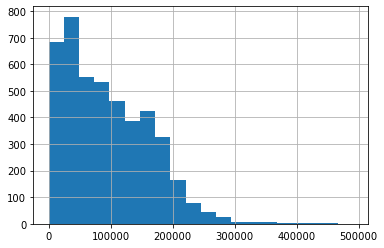

In [12]:
count['count'].hist(bins=20)

In [13]:
latb = np.arange(-80.,80,1.)
count['lat_cut'] = pd.cut(count['lat'],latb)

<AxesSubplot:xlabel='count'>

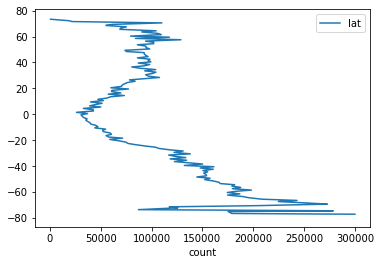

In [14]:
count.groupby('lat_cut').mean().plot(x='count',y='lat')

<AxesSubplot:>

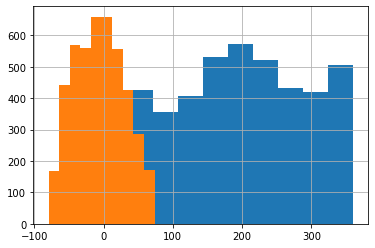

In [15]:
count['lon'].hist()
count['lat'].hist()

In [21]:
import pyinterp
mesh = pyinterp.RTree()

In [23]:
lons = count['lon'].values
lats = count['lat'].values
c = count['count'].values
mesh.packing(np.vstack((lons, lats)).T, c)

In [43]:
x0, x1 = -180, 180
y0, y1 = -80, 80
dl = .5
mx, my = np.meshgrid(
    np.arange(x0, x1, dl),
    np.arange(y0, y1, dl),
    indexing="ij")

c_ll, neighbors = mesh.inverse_distance_weighting(
    np.vstack((mx.flatten(), my.flatten())).T,
    within=False,
    radius=1000e3,  # 100 Km
    k=1,
    num_threads=0)
c_ll = c_ll.reshape(mx.shape)

In [44]:
ds = xr.Dataset(data_vars=dict(count=(['x','y'], c_ll)), 
                coords=dict(lon=(["x", "y"], mx),
                            lat=(["x", "y"], my),
                           )
               )

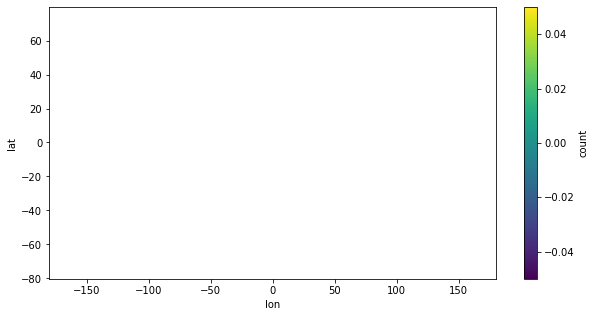

In [45]:
ds['count'].plot(x='lon',y='lat', figsize=(10,5))

In [42]:
mesh.inverse_distance_weighting?

Signature:
mesh.inverse_distance_weighting(
    coordinates: numpy.ndarray,
    radius: Union[float, NoneType] = None,
    k: Union[int, NoneType] = 9,
    p: Union[int, NoneType] = 2,
    within: Union[bool, NoneType] = True,
    num_threads: Union[int, NoneType] = 0,
) -> Tuple[numpy.ndarray, numpy.ndarray]
Docstring:
Interpolation of the value at the requested position by inverse
distance weighting method.

Args:
    coordinates (numpy.ndarray): a matrix ``(n, ndims)`` where ``n`` is
        the number of observations and ``ndims`` is the number of
        coordinates in order: longitude and latitude in degrees,
        altitude in meters and then the other coordinates defined in
        Euclidean space if ``dims`` > 3. If the shape of the matrix is
        ``(n, ndims)`` then the method considers the altitude constant
        and equal to zero.
    radius (float, optional): The maximum radius of the search (m).
        Defaults The maximum distance between two points.
    k (int, o

In [19]:
c = count.sort_values('lon').sort_value
x_axis = pyinterp.Axis(c['lon'].values, is_circle=True)
y_axis = pyinterp.Axis(c['lat'].values)

ValueError: axis values are not ordered

In [55]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

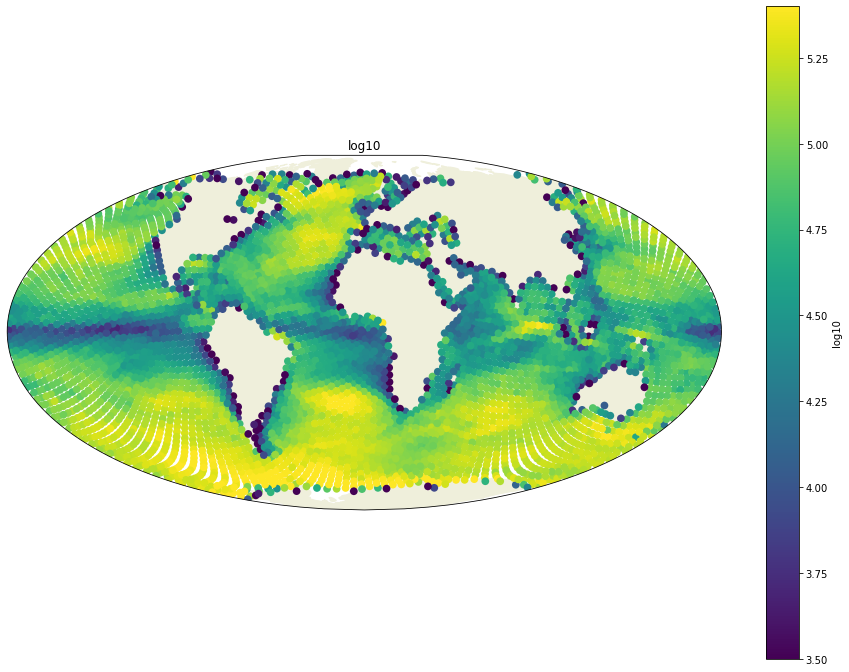

In [67]:
def plot_h3_simple(df, 
                   metric_col, 
                   x='lon', 
                   y='lat', 
                   marker='o', 
                   alpha=1, 
                   figsize=(16,12), 
                   colormap='viridis',
                   **kwargs,
                  ):
    
    #_projection = ccrs.Robinson()
    #_projection = ccrs.EqualEarth()
    _projection = ccrs.Mollweide()
    #_projection = ccrs.Geodetic()
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection=_projection)
    
    df.plot.scatter(x=x, 
                    y=y,
                    c=metric_col,
                    title=metric_col,
                    edgecolors='none', 
                    colormap=colormap, 
                    marker=marker, 
                    alpha=alpha,
                    ax=ax,
                    transform=ccrs.PlateCarree(),
                    **kwargs
                   )
    #plt.xticks([], [])
    #plt.yticks([], [])
    ax.add_feature(cfeature.LAND)

plot_h3_simple(count, 'log10', vmin=3.5, vmax=5.4, s=60)

In [77]:
from shapely.geometry import Polygon
import geopandas as gpd

In [75]:
def add_geometry(row):
    points = h3.h3_to_geo_boundary(
      row['hex_id'], True)
    return Polygon(points)
 
count['geometry'] = count.apply(add_geometry, axis=1)

In [78]:
gdf = gpd.GeoDataFrame(count, crs='EPSG:4326')

In [84]:
gdf

,hex_id,count,lat,lon,log10,geometry
0,820127fffffffff,53369,70.683933,24.354967,4.727289,"POLYGON ((24.49265 69.30502, 28.25587 69.84475..."
1,82012ffffffffff,2109,72.849465,19.561607,3.324077,"POLYGON ((20.12325 71.43480, 24.19275 72.09707..."
2,820137fffffffff,4202,70.309462,32.289290,3.623456,"POLYGON ((31.83128 68.92996, 35.78098 69.30326..."
3,82024ffffffffff,2342,71.558013,-78.060813,3.369587,"POLYGON ((-76.58894 73.22980, -82.33427 72.711..."
4,82025ffffffffff,22463,72.039305,-87.719205,4.351468,"POLYGON ((-87.11740 73.75309, -92.57167 72.956..."
...,...,...,...,...,...,...
4489,82f35ffffffffff,250016,-73.790250,-135.886219,5.397968,"POLYGON ((-141.35590 -73.54374, -139.98860 -75..."
4490,82f367fffffffff,260701,-70.309462,-147.710710,5.416143,"POLYGON ((-151.74413 -69.84475, -151.56695 -71..."
4491,82f36ffffffffff,258506,-69.588209,-140.066592,5.412471,"POLYGON ((-144.21902 -69.30326, -143.42110 -70..."
4492,82f377fffffffff,213974,-72.680492,-151.356811,5.330361,"POLYGON ((-155.80725 -72.09707, -156.00121 -73..."


In [109]:
import pyinterp
mesh = pyinterp.RTree()

In [139]:
_df = count.sort_values('lon')

In [141]:
_df

,hex_id,count,lat,lon,log10,geometry,lat_cut
4388,82eab7fffffffff,149848,-60.483591,-539.974768,5.175651,"POLYGON ((-177.23247 -60.73321, -177.80178 -59...","(-61.0, -60.0]"
2103,827f87fffffffff,18649,-4.530451,-539.941761,4.270656,"POLYGON ((-179.69020 -5.86452, -178.57401 -4.7...","(-5.0, -4.0]"
1332,825ab7fffffffff,82197,19.075378,-539.905570,4.914856,"POLYGON ((-178.95064 17.74333, -178.12301 19.2...","(19.0, 20.0]"
4024,82db17fffffffff,134864,-53.652814,-539.785741,5.129896,"POLYGON ((-177.40721 -53.99775, -177.89869 -52...","(-54.0, -53.0]"
1357,825b9ffffffffff,72742,16.278267,-539.755538,4.861785,"POLYGON ((-178.83217 14.99532, -178.02848 16.4...","(16.0, 17.0]"
...,...,...,...,...,...,...,...
2634,829b47fffffffff,79929,-18.385478,-180.196959,4.902704,"POLYGON ((-179.91416 -19.97420, -178.63997 -18...","(-19.0, -18.0]"
1328,825a97fffffffff,91112,21.955975,-180.065487,4.959576,"POLYGON ((-179.07678 20.57925, -178.22377 22.0...","(21.0, 22.0]"
2606,829a47fffffffff,79173,-11.176735,-180.061070,4.898577,"POLYGON ((-179.79479 -12.65218, -178.60482 -11...","(-12.0, -11.0]"
1,82012ffffffffff,2109,72.849465,19.561607,3.324077,"POLYGON ((20.12325 71.43480, 24.19275 72.09707...","(72.0, 73.0]"


In [136]:
x_axis = pyinterp.Axis(gdf['lon'].values, is_circle=True)
y_axis = pyinterp.Axis(gdf['lat'].values)

ValueError: axis values are not ordered

In [137]:
gdf['lon'].values

array([  24.35496699,   19.56160684, -327.71071018, ..., -500.06659204,
       -511.35681133, -532.56787679])

In [113]:
lons = gdf['lon'].values
lats = gdf['lat'].values
c = count['count'].values

In [127]:
mesh.packing(np.vstack((lons, lats)).T, c)

In [128]:
x0, x1 = 80, 170
y0, y1 = -45, 30
mx, my = np.meshgrid(
    np.arange(x0, x1, 1/32.0),
    np.arange(y0, y1, 1/32.0),
    indexing="ij")

eta, neighbors = mesh.inverse_distance_weighting(
    np.vstack((mx.flatten(), my.flatten())).T,
    within=False,
    radius=35500,  # 35.5 Km
    k=9,
    num_threads=0)

In [135]:
mesh.

SyntaxError: invalid syntax (<ipython-input-135-9e64abfbd0a9>, line 1)

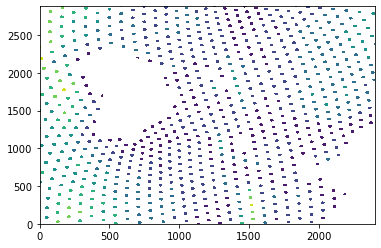

In [134]:
plt.contourf(eta.reshape(mx.shape))

In [ ]:
import intake

cat_url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore" \
    "/master/intake-catalogs/ocean/llc4320.yaml"
cat = intake.Catalog(cat_url)

# Grid subsampling (orginal volume is too huge for this example)
indices = slice(0, None, 8)

# Reads longitudes and latitudes of the grid
array = cat.LLC4320_grid.to_dask()
lons = array["XC"].isel(i=indices, j=indices)
lats = array["YC"].isel(i=indices, j=indices)

# Reads SSH values for the first time step of the time series
ssh = cat.LLC4320_SSH.to_dask()
ssh = ssh["Eta"].isel(time=0, i=indices, j=indices)

# Populates the search tree
mesh.packing(
    np.vstack((lons.values.flatten(), lats.values.flatten())).T,
    ssh.values.flatten())

In [100]:
ax.add_geometries?

Object `ax.add_geometries` not found.


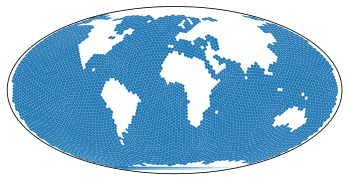

In [106]:
#_projection = ccrs.Robinson()
_projection = ccrs.Mollweide()

# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = _projection.proj4_init
dlon = 5
_gdf = gdf[(gdf['lon']<180-dlon)&(gdf['lon']>-180+dlon)]
df_pr = _gdf.to_crs(crs_proj4)

fig, ax = plt.subplots(subplot_kw={'projection': _projection})
ax.add_geometries(df_pr['geometry'], crs=_projection)

In [108]:
ax.add_geometries?

Signature: ax.add_geometries(geoms, crs, **kwargs)
Docstring:
Add the given shapely geometries (in the given crs) to the axes.

Parameters
----------
geoms
    A collection of shapely geometries.
crs
    The cartopy CRS in which the provided geometries are defined.
styler
    A callable that returns matplotlib patch styling given a geometry.

Returns
-------
A :class:`cartopy.mpl.feature_artist.FeatureArtist` instance
    The instance responsible for drawing the feature.

Note
----
    Matplotlib keyword arguments can be used when drawing the feature.
    This allows standard Matplotlib control over aspects such as
    'facecolor', 'alpha', etc.
File:      ~/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py
Type:      method


In [94]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

<AxesSubplot:>

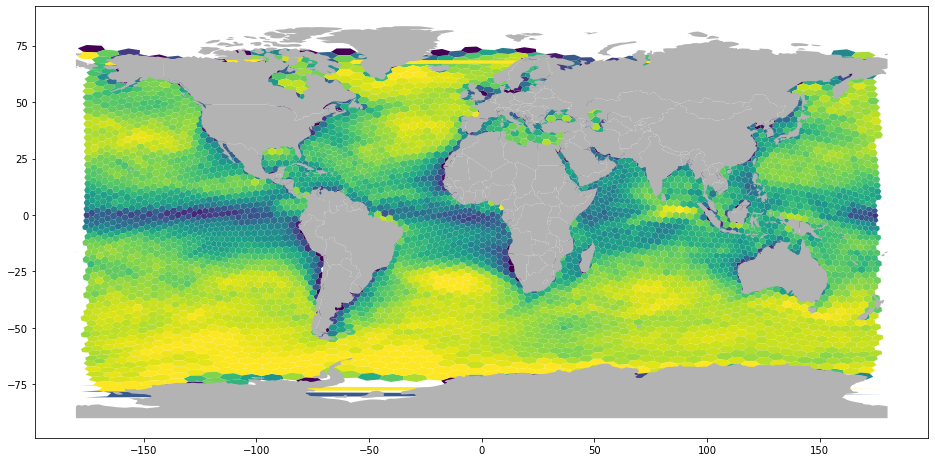

In [99]:
dlon = 5
_gdf = gdf[(gdf['lon']<180-dlon)&(gdf['lon']>-180+dlon)]
ax = _gdf.plot(column='log10', vmin=3.5, vmax=5.4, figsize=(16,12))
#ax.add_feature(cfeature.LAND)
world.plot(ax=ax, facecolor='0.7')

In [ ]:
gdf['count'].map

In [68]:
from h3 import h3

In [73]:
h3.h3_to_geo_boundary('820127fffffffff')

((69.30502245348691, 24.49264698397638),
 (69.84474595092315, 28.255869905697548),
 (71.24542771505135, 28.43305176155628),
 (72.09707420590917, 24.192747647371593),
 (71.43479800589196, 20.12325313539589),
 (70.05215151950887, 20.59724429383497))

In [17]:
ax = plt.axes(projection=ccrs.Robinson())

[line] = ax.plot([-60, 60], [60, 60], 'ob', linestyle='-', transform=ccrs.Geodetic())

# Fiddle with the line's type. Polymorphism... with great power comes great responsibility.
line.__class__ = Line2DNoMarkerInterp

ax.set_global()
ax.coastlines(alpha=0.2)

plt.show()


In [ ]:
---

## make movie

In [28]:
df = (df
      .repartition(npartitions=500)
     ).persist()
#      .set_index('time')
#     .repartition(npartitions=500)

In [5]:
df_pd = df.compute()

In [6]:
df_pd.set_index('time', inplace=True)

In [7]:
df_pd

,lat,lon,z
time,,,
2011-11-15 00:00:00,41.797028,-34.864582,0.0
2011-11-15 00:00:00,42.514122,-34.864582,0.0
2011-11-15 00:00:00,43.223770,-34.864582,0.0
2011-11-15 00:00:00,43.925968,-34.864582,0.0
2011-11-15 00:00:00,44.620720,-34.864582,0.0
...,...,...,...
2012-11-14 01:00:00,66.741574,71.627916,0.0
2012-11-14 01:00:00,66.764272,71.887481,0.0
2012-11-14 01:00:00,67.327208,72.672317,0.0


In [29]:
df_s = df.set_index('time').persist()

TypeError: '<' not supported between instances of 'NoneType' and 'int'

In [22]:
t0 = df['time'].min().compute()

Timestamp('2011-11-15 00:00:00')

In [15]:


df['iteration'] = df['time'] - df['time'].min()

,time,lat,lon,z
npartitions=7667,,,,
,datetime64[ns],float64,float64,float64
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


In [20]:
df.repartition(npartitions=500)

Signature:
df.repartition(
    divisions=None,
    npartitions=None,
    partition_size=None,
    freq=None,
    force=False,
)
Docstring:
Repartition dataframe along new divisions

Parameters
----------
divisions : list, optional
    List of partitions to be used. Only used if npartitions and
    partition_size isn't specified.
npartitions : int, optional
    Number of partitions of output. Only used if partition_size
    isn't specified.
partition_size: int or string, optional
    Max number of bytes of memory for each partition. Use numbers or
    strings like 5MB. If specified npartitions and divisions will be
    ignored.

    .. warning::

       This keyword argument triggers computation to determine
       the memory size of each partition, which may be expensive.

freq : str, pd.Timedelta
    A period on which to partition timeseries data like ``'7D'`` or
    ``'12h'`` or ``pd.Timedelta(hours=12)``.  Assumes a datetime index.
force : bool, default False
    Allows the expansio

In [12]:
df_pd = df.compute()

In [16]:
df_pd.set_index('time', inplace=True)

In [18]:
df_pd

,lat,lon,z
time,,,
2011-11-15 00:00:00,41.797028,-34.864582,0.0
2011-11-15 00:00:00,42.514122,-34.864582,0.0
2011-11-15 00:00:00,43.223770,-34.864582,0.0
2011-11-15 00:00:00,43.925968,-34.864582,0.0
2011-11-15 00:00:00,44.620720,-34.864582,0.0
...,...,...,...
2012-11-14 01:00:00,66.741574,71.627916,0.0
2012-11-14 01:00:00,66.764272,71.887481,0.0
2012-11-14 01:00:00,67.327208,72.672317,0.0


In [17]:
df_pd.set_index?

Signature:
df_pd.set_index(
    keys,
    drop=True,
    append=False,
    inplace=False,
    verify_integrity=False,
)
Docstring:
Set the DataFrame index using existing columns.

Set the DataFrame index (row labels) using one or more existing
columns or arrays (of the correct length). The index can replace the
existing index or expand on it.

Parameters
----------
keys : label or array-like or list of labels/arrays
    This parameter can be either a single column key, a single array of
    the same length as the calling DataFrame, or a list containing an
    arbitrary combination of column keys and arrays. Here, "array"
    encompasses :class:`Series`, :class:`Index`, ``np.ndarray``, and
    instances of :class:`~collections.abc.Iterator`.
drop : bool, default True
    Delete columns to be used as the new index.
append : bool, default False
    Whether to append columns to existing index.
inplace : bool, default False
    Modify the DataFrame in place (do not create a new object).
ver

---

## load llc data

In [6]:
%%time
if False:
    # load llc data
    ds = ut.load_data(V=['SST', 'SSU', 'SSV'])
    grd = ut.load_grd()[['XC', 'YC', 'XG', 'YG']]
    ds = xr.merge([ds, grd])
    ds

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.05 µs


---

## create tiles - !!! should be deleted eventually

This could be done somewhere else, in another notebook

See `rearrange.ipynb` and `tile.ipynb` for more details

** Several tiles in the south and north tiles could be deleted eventually as they are on land or not relevant

In [7]:
%%time

create_tiles = False

tile_dir = os.path.join(run_dir,'tiling/')
#tile_dir = '/home1/scratch/aponte/parcels/tile_tmp/'
if create_tiles:
    
    # ** could filter out tiles that are empty, criterium on Depth or SST should be sufficient

    # create tiler
    #tl = pa.tiler(ds=grd.reset_coords(), factor=(10, 10), overlap=(100, 100))
    #tl = pa.tiler(ds=grd.reset_coords(), factor=(5, 20), overlap=(100, 100))
    tl = pa.tiler(ds=grd.reset_coords(), factor=(5, 5), overlap=(100, 100))
    # store tiler
    tl.store(tile_dir)
    
else:
    
    #tile_dir = ut.root_data_dir+'parcels/tiling/'
    #tile_dir = os.path.join(run_dir,'tiling/')
    tl = pa.tiler(tile_dir=tile_dir)
    
tile_data_dirs = [os.path.join(run_dir,'data_{:03d}'.format(t)) 
                  for t in range(tl.N_tiles)
                 ]

CPU times: user 432 ms, sys: 56 ms, total: 488 ms
Wall time: 482 ms


---
## load dataset and plot a subset of trajectories

In [8]:
float_files = []
for _dir in tile_data_dirs:
    float_files.extend(sorted(glob.glob(_dir+"/floats_*.nc")))
    #float_files.extend(sorted(glob.glob(_dir+"/floats_364*.nc")))
print(float_files[:5])
print(float_files[-5:])

['/home1/datawork/slgentil/parcels/global_T365j_dt1j_dij50/data_001/floats_000_001.nc', '/home1/datawork/slgentil/parcels/global_T365j_dt1j_dij50/data_001/floats_001_001.nc', '/home1/datawork/slgentil/parcels/global_T365j_dt1j_dij50/data_001/floats_002_001.nc', '/home1/datawork/slgentil/parcels/global_T365j_dt1j_dij50/data_001/floats_003_001.nc', '/home1/datawork/slgentil/parcels/global_T365j_dt1j_dij50/data_001/floats_004_001.nc']
['/home1/datawork/slgentil/parcels/global_T365j_dt1j_dij50/data_024/floats_360_024.nc', '/home1/datawork/slgentil/parcels/global_T365j_dt1j_dij50/data_024/floats_361_024.nc', '/home1/datawork/slgentil/parcels/global_T365j_dt1j_dij50/data_024/floats_362_024.nc', '/home1/datawork/slgentil/parcels/global_T365j_dt1j_dij50/data_024/floats_363_024.nc', '/home1/datawork/slgentil/parcels/global_T365j_dt1j_dij50/data_024/floats_364_024.nc']


In [9]:
def xr2df(file):
    return xr.open_dataset(file).to_dataframe().set_index('trajectory')

lazy_dataframes = [delayed(xr2df)(f) for f in float_files]

In [10]:
%%time
_df = lazy_dataframes[0].compute()

CPU times: user 24 ms, sys: 12 ms, total: 36 ms
Wall time: 2.34 s


In [11]:
%%time
df = dd.from_delayed(lazy_dataframes, meta=_df)

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 25 ms


In [12]:
%%time
df_pd = df.compute() # load in notebook, dangerous !!

CPU times: user 49.8 s, sys: 38 s, total: 1min 27s
Wall time: 2min 28s


In [13]:
print(df_pd['time'].min())
print(df_pd['time'].max())

2011-11-15 00:00:00
2012-11-14 01:00:00


## Find lost trajectories

In [14]:
%%time
df_gb = df_pd.groupby([df_pd.index])
df_ct = df_gb.count()
df_ct

CPU times: user 21.7 s, sys: 3.59 s, total: 25.3 s
Wall time: 25 s


,time,lat,lon,z
trajectory,,,,
1000000.0,1560,1560,1560,1560
1000001.0,9490,9490,9490,9490
1000002.0,9490,9490,9490,9490
1000003.0,9490,9490,9490,9490
1000004.0,9490,9490,9490,9490
...,...,...,...,...
24001561.0,9490,9490,9490,9490
24001562.0,9490,9490,9490,9490
24001563.0,9490,9490,9490,9490


In [15]:
nbtimes = df_ct['time'].max()
print(nbtimes)
dlost = df_ct[df_ct['time'] != nbtimes].index
#dlost = df_ct[df_ct['time'] < 97].index
print(f'Nombre de flotteurs perdus: {dlost.size:5d} ({dlost.size/len(df_ct.index):%})')
dlost

9490
Nombre de flotteurs perdus:  8871 (17.753717%)


Float64Index([ 1000000.0,  1000051.0,  1000074.0,  1000102.0,  1000153.0,
               1000204.0,  1000205.0,  1000255.0,  1000294.0,  1000306.0,
              ...
              24001509.0, 24001510.0, 24001514.0, 24001533.0, 24001535.0,
              24001545.0, 24001550.0, 24001552.0, 24001560.0, 24001565.0],
             dtype='float64', name='trajectory', length=8871)

## Plot last position of lost floats

In [16]:
%%time
_d = df_pd[df_pd.index.isin(dlost)]
_d = _d.groupby('trajectory').last()
#_d = _d[_d['time'].dt.hour==1]
#_d = _d[_d['time'] == pd.Timestamp(2011,11,16,1)]
#_d = _d[(_d['lon']>-40) & (_d['lon']<-30) & (_d['lat']>-40) & (_d['lat']<20)]

print(_d)
gdf = geopandas.GeoDataFrame(_d, geometry=geopandas.points_from_xy(_d.lon, _d.lat))

                          time        lat        lon    z
trajectory                                               
1000000.0  2012-01-14 01:00:00 -71.930735 -38.526908  0.0
1000051.0  2012-01-20 01:00:00 -71.960066 -34.413193  0.0
1000074.0  2012-02-01 01:00:00 -59.012785 -26.600780  0.0
1000102.0  2012-01-20 01:00:00 -71.943650 -36.608227  0.0
1000153.0  2012-02-15 01:00:00 -71.977897 -36.497171  0.0
...                        ...        ...        ...  ...
24001545.0 2011-11-21 01:00:00  57.578132 -35.009414  0.0
24001550.0 2011-11-20 01:00:00  59.769384 -35.267590  0.0
24001552.0 2011-11-24 01:00:00  61.065363 -35.092453  0.0
24001560.0 2011-12-30 01:00:00  59.595141 -35.366415  0.0
24001565.0 2012-07-21 01:00:00  65.776164 -36.409511  0.0

[8871 rows x 4 columns]
CPU times: user 1min 12s, sys: 10.9 s, total: 1min 23s
Wall time: 1min 22s


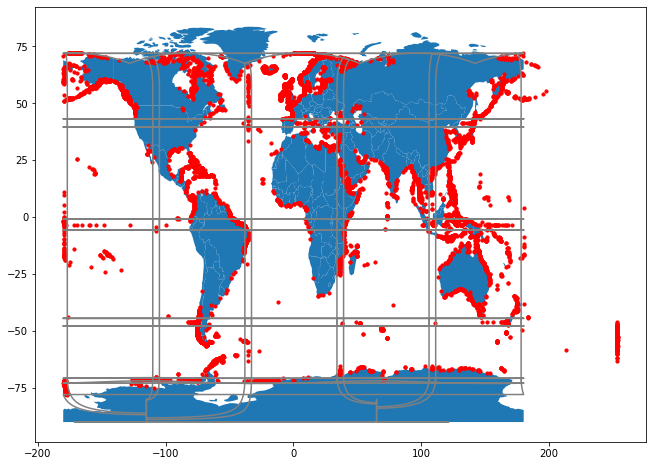

In [17]:
world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
crs = tl.crs_wgs84

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
world.plot(ax=ax)
gdf.plot(ax=ax, color='red', markersize=10)
#ax.set_axis_off()
#ax.set_xlim(xmin=-110, xmax=40)
#ax.set_ylim(ymin=-10, ymax=50)
#plt.show()
for t in tl.G['tiles']:
    t.to_crs(crs).boundary.plot(ax=ax, color="grey")
#for b in tl.G['boundaries']:
#    b.to_crs(crs).boundary.plot(ax=ax, color="red")
#tl.G['boundaries'][3].to_crs(crs).boundary.plot(ax=ax, color="black")  
#tl.G['boundaries'][23].to_crs(crs).boundary.plot(ax=ax, color="red")  
#tl.G['tiles'][3].to_crs(crs).boundary.plot(ax=ax, color="grey")     
#tl.G['tiles'][23].to_crs(crs).boundary.plot(ax=ax, color="grey")  

### plot last time

In [18]:
%%time
_d = df_pd[df_pd['time']==df_pd['time'].max()]
gdf = geopandas.GeoDataFrame(_d, geometry=geopandas.points_from_xy(_d.lon, _d.lat))

CPU times: user 3.76 s, sys: 1.61 s, total: 5.36 s
Wall time: 5.27 s


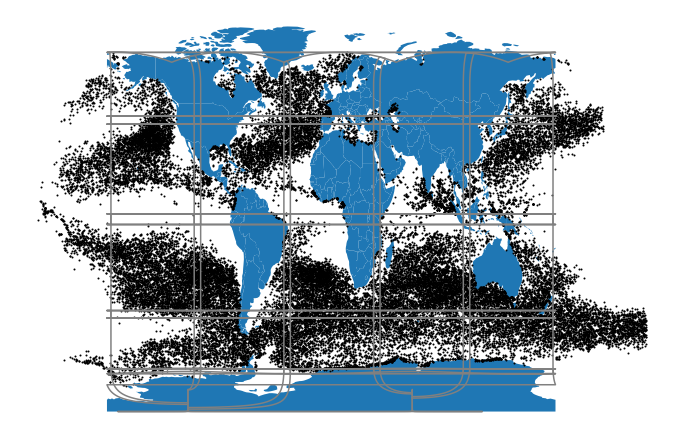

In [19]:
world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
crs = tl.crs_wgs84

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
world.plot(ax=ax)
gdf.plot(ax=ax, color='k', markersize=1)
ax.set_axis_off()
#plt.show()
for t in tl.G['tiles']:
    t.to_crs(crs).boundary.plot(ax=ax, color='0.5')

## Plot uncomplete trajectory

In [ ]:
%%time
_d = df_pd[df_pd.index.isin(dlost)]
_d = _d.groupby('trajectory')
keys = list(_d.groups.keys())[::100]
_d = _d.filter(lambda x: x.name in keys)
gdf = geopandas.GeoDataFrame(_d, geometry=geopandas.points_from_xy(_d.lon, _d.lat))

world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
crs = tl.crs_wgs84

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
world.plot(ax=ax)
gdf.plot(ax=ax, color='r', markersize=1)
#ax.set_axis_off()
#plt.show()
for t in tl.G['tiles']:
    t.to_crs(crs).boundary.plot(ax=ax, color='0.5')

## Plot a complete trajectory

In [ ]:
%%time
_dg = df_pd[~df_pd.index.isin(dlost)].groupby('trajectory')
keys = list(_dg.groups.keys())[::1000]
_d = _dg.filter(lambda x: x.name in keys)

gdf = geopandas.GeoDataFrame(_d, geometry=geopandas.points_from_xy(_d.lon, _d.lat))

world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
crs = tl.crs_wgs84

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
world.plot(ax=ax)
gdf.plot(ax=ax, color='r', markersize=0.5)
#ax.set_axis_off()
#plt.show()
for t in tl.G['tiles']:
    t.to_crs(crs).boundary.plot(ax=ax, color='0.5')

## Close cluster

In [ ]:
cluster.close()